In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ts_val_shuffle import FeaturesGenerator, Validator, MAPE, SMAPE, WAPE

c:\University\kurs_3\semestr_2\практика\TSValShuffle\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\University\kurs_3\semestr_2\практика\TSValShuffle\venv\Lib\site-packages\symfit\core\printing.py:13: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


## Для теста выбран датасет [Electric Production](https://www.kaggle.com/datasets/shenba/time-series-datasets/data?select=Electric_Production.csv)

In [2]:
df = pd.read_csv(r"data\Electric_Production.csv")

df = df.rename(columns={"IPG2211A2N": "value", "DATE": "date"})

df['date'] = pd.to_datetime(df['date'])
print(df.head())

        date    value
0 1985-01-01  72.5052
1 1985-02-01  70.6720
2 1985-03-01  62.4502
3 1985-04-01  57.4714
4 1985-05-01  55.3151


In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    397 non-null    datetime64[ns]
 1   value   397 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 6.3 KB
None


In [4]:
train = df.iloc[:-48]
test = df.iloc[-48:]

## Пример с использованием ExponentialSmoothing из библиотеки statsmodels

### Инициализируется валидатор

Для работы нужно выполнить 3 этапа:
1) Инициализировать исходный временный ряд;
2) Сгенерировать признаки, передав путь к JSON файлу;
3) Установить параметры инициализации и кросс-валидации, передав путь к JSON файлу;
4) Провести кросс-валидацию модели, задав метрику, название целевого признака и временного признака из исходных данных

In [5]:
val = Validator()

val.set_data(train)
val.set_generator(r"data\configs\features\config.json")
val.load_params(r"data\configs\params\validation_params_expsmoothing.json")
val.validate()

c:\University\kurs_3\semestr_2\практика\TSValShuffle\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\University\kurs_3\semestr_2\практика\TSValShuffle\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\University\kurs_3\semestr_2\практика\TSValShuffle\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\University\kurs_3\semestr_2\практика\TSValShuffle\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\University\kurs_3\semestr_2\практика\TSVa

In [6]:
print(pd.Series(val.metric_values))

0    0.025270
1    0.035051
2    0.033553
3    0.025194
4    0.025516
5    0.022589
6    0.034334
7    0.031490
8    0.051082
9    0.040518
dtype: float64


### Значения метрики WAPE в процессе кросс-валидации

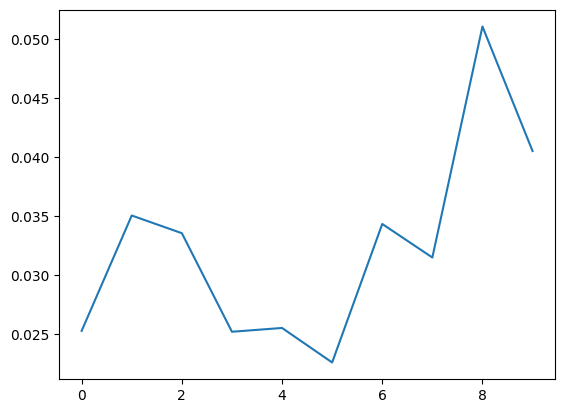

In [7]:
plt.plot(val.metric_values)
plt.show()

### Генерируем признаки для теста обученной модели

In [8]:
gen = FeaturesGenerator(r"data\configs\features\empty_config.json")
test = gen.generate_features(test)

print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 349 to 396
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    48 non-null     datetime64[ns]
 1   value   48 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 900.0 bytes
None


In [9]:
print(test.head())

          date     value
349 2014-02-01  112.8811
350 2014-03-01  104.7631
351 2014-04-01   90.2867
352 2014-05-01   92.1340
353 2014-06-01  101.8780


### Предсказываем на выборке, которую модель ещё не видела

In [10]:
predict_params = {
    "steps": len(test)
}
pred = val.forecast(predict_params)

print(pred.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48 entries, 2011-08-01 to 2015-07-01
Freq: MS
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       48 non-null     float64
dtypes: float64(1)
memory usage: 768.0 bytes
None


In [11]:
print(pred.head())

                     0
2011-08-01  112.328084
2011-09-01  100.636705
2011-10-01   92.880747
2011-11-01   95.491306
2011-12-01  113.197800


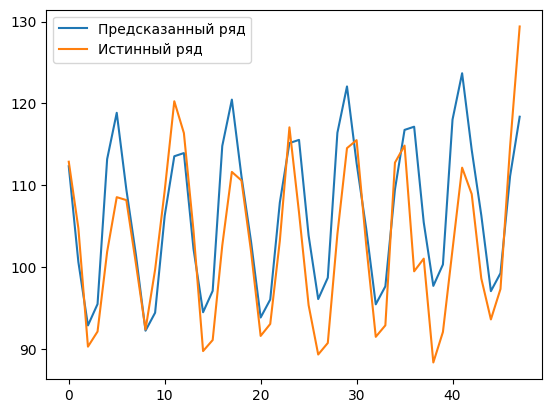

In [12]:
plt.plot(np.arange(0, 48), pred[pred.columns[0]].values[-48:], label='Предсказанный ряд')
plt.plot(np.arange(0, 48), df['value'][-48:], label='Истинный ряд')
plt.legend()
plt.show()

### Сравнение предсказанных и истинных данных

In [13]:
res = pd.DataFrame({
    'date': df['date'][-48:].values,
    'y_pred': pred[pred.columns[0]].values[-48:],
    'y_true': df['value'][-48:].values
})
print(res)

         date      y_pred    y_true
0  2014-02-01  112.328084  112.8811
1  2014-03-01  100.636705  104.7631
2  2014-04-01   92.880747   90.2867
3  2014-05-01   95.491306   92.1340
4  2014-06-01  113.197800  101.8780
5  2014-07-01  118.857057  108.5497
6  2014-08-01  109.502036  108.1940
7  2014-09-01  101.503051  100.4172
8  2014-10-01   92.237136   92.3837
9  2014-11-01   94.432935   99.7033
10 2014-12-01  106.285050  109.3477
11 2015-01-01  113.548154  120.2696
12 2015-02-01  113.938266  116.3788
13 2015-03-01  102.246887  104.4706
14 2015-04-01   94.490929   89.7461
15 2015-05-01   97.101488   91.0930
16 2015-06-01  114.807982  102.6495
17 2015-07-01  120.467239  111.6354
18 2015-08-01  111.112218  110.5925
19 2015-09-01  103.113233  101.9204
20 2015-10-01   93.847318   91.5959
21 2015-11-01   96.043117   93.0628
22 2015-12-01  107.895231  103.2203
23 2016-01-01  115.158336  117.0837
24 2016-02-01  115.548448  106.6688
25 2016-03-01  103.857069   95.3548
26 2016-04-01   96.101111   

### Значение метрики WAPE в данном случае

In [14]:
print(WAPE(res['y_true'], res['y_pred']))

0.05288822318446457
